In [1]:
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD.configuration import Configuration
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import pandas as pd
%matplotlib inline

from scipy.stats import expon


This notebook uses the differential games framework developed by BlockScience. It is currently in private beta, and building towards a full open source release.

**Description:**

cadCAD is a Python library that assists in the processes of designing, testing and validating complex systems through simulation. At its core, cadCAD is a differential games engine that supports parameter sweeping and Monte Carlo analyses and can be easily integrated with other scientific computing Python modules and data science workflows.

To learn more about cadCAD, follow our [tutorial series](https://github.com/BlockScience/cadCAD-Tutorials/tree/master/01%20Tutorials)

**Installing cadCAD:**

cadCAD is in private beta. Tokens are issued to participants. Replace `<TOKEN>` in the installation URL below
```bash
pip3 install cadCAD --extra-index-url https://<TOKEN>@repo.fury.io/blockscience/
```

If you'd like to participate in the beta program, contact cadcad [at] block [dot] science.


In [20]:
#helper functions
def get_nodes_by_type(g, node_type_selection):
    return [node for node in g.nodes if g.nodes[node]['type']== node_type_selection ]

def get_edges_by_type(g, edge_type_selection):
    return [edge for edge in g.edges if g.edges[edge]['type']== edge_type_selection ]


In [19]:
#generate an initial set of 'n' participants
network = nx.DiGraph()
n = 100
for i in range(n):
    network.add_node(i)
    network.nodes[i]['type']="participant"
    
    h_rv = expon.rvs(loc=0.001, scale=1000)
    network.nodes[i]['holdings'] = h_rv
    
    s_rv = np.random.rand() 
    network.nodes[i]['sentiment'] = s_rv

participants = get_nodes_by_type(network, 'participant')
initial_supply = np.sum([ network.nodes[i]['holdings'] for i in participants])
print(initial_supply)

initial_funds = initial_supply


92089.22219636562


In [21]:
#generate initial proposals
m = 12
for j in range(m):
    ind = n+j
    network.add_node(ind)
    network.nodes[ind]['type']="proposal"
    network.nodes[ind]['conviction']=0
    network.nodes[ind]['status']='candidate'
    network.nodes[ind]['age']=0
    
    r_rv = expon.rvs(loc=0.001, scale=10000)
    network.node[ind]['funds_requested'] = r_rv
    
    for i in range(n):
        network.add_edge(i, ind)
        
        a_rv = np.random.rand() 
        network.edges[(i, ind)]['affinity'] = a_rv
        network.edges[(i,ind)]['tokens'] = a_rv*network.nodes[i]['holdings']
        network.edges[(i, ind)]['conviction'] = 0

proposals = get_nodes_by_type(network, 'proposal')
total_requested = np.sum([ network.nodes[i]['funds_requested'] for i in proposals])
print(total_requested/initial_funds)

1.7484479178693189


In [22]:
network.nodes[get_nodes_by_type(network, 'proposal')[0]]

{'type': 'proposal',
 'conviction': 0,
 'status': 'candidate',
 'funds_requested': 10417.252006928056}

In [23]:
network.nodes[get_nodes_by_type(network, 'participant')[0]]

{'type': 'participant',
 'holdings': 1307.1683720857025,
 'sentiment': 0.008125570765641466}

Text(0.5, 1.0, 'Histogram of Participants Token Holdings')

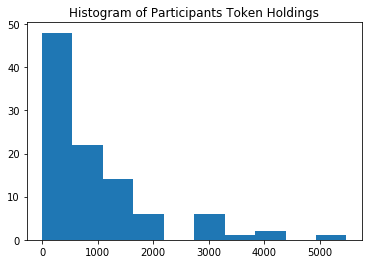

In [31]:
plt.hist([ network.nodes[i]['holdings'] for i in participants])
plt.title('Histogram of Participants Token Holdings')

Text(0.5, 1.0, 'Histogram of Proposals Funds Requested')

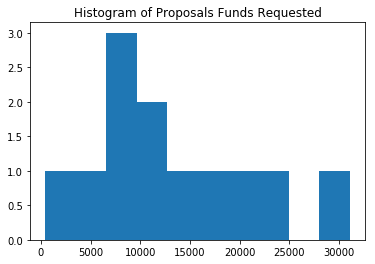

In [33]:
plt.hist([ network.nodes[i]['funds_requested'] for i in proposals])
plt.title('Histogram of Proposals Funds Requested')

Text(0.5, 1.0, 'Histogram of Affinities between Participants and Proposals')

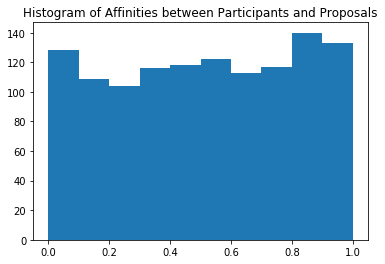

In [34]:
plt.hist([ network.edges[e]['affinity'] for e in network.edges])
plt.title('Histogram of Affinities between Participants and Proposals')

Text(0.5, 1.0, 'Histogram of Affinities between Participants and Proposals weighted by holdings')

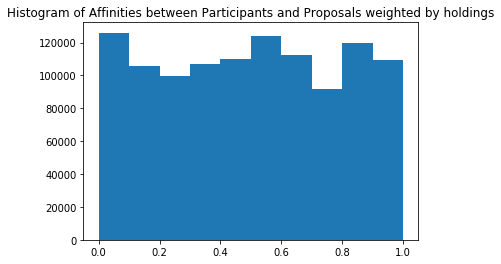

In [42]:
plt.hist([ network.edges[e]['affinity'] for e in network.edges], weights = [network.nodes[e[0]]['holdings']for e in network.edges],alpha = 1)
plt.title('Histogram of Affinities between Participants and Proposals weighted by holdings')

In [44]:
T = 50 #iterations of graph update in our simulation
#param for conviction accumilation
alpha = .01 #later we should set this to be param so we can sweep it

#sentiment of the outside world which drives grants
initial_sentiment = .5

#sentiment decay rate
gamma =.001 #later we should set this to be param so we can sweep it

#maximum share of funds a proposal can take
beta = .2 #later we should set this to be param so we can sweep it
# tuning param for the trigger function
rho = 1

#minimum periods passed before a proposal can pass
tmin = 7


In [45]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# We'll cover the `M` key in a future article. For now, let's leave it empty
simulation_parameters = {
    'T': range(T),
    'N': 1,
    'M': {}
}

In [46]:
initial_conditions = {'network':network,
                      'supply': initial_supply,
                      'funds':initial_funds,
                      'sentiment': initial_sentiment}

In [ ]:
#functions for partial state update block 1

def driving_process(params, step, sL, s):
    
    #placeholder plumbing for random process
    
    return({'new_participant':False, 'new_proposal':False})

def update_network(params, step, sL, s, _input):
    
    network = s['network']
    #placeholder plumbing for new proposals and new participants
    new_participant = _input['new_participant'] #T/F
    new_proposal = _input['new_proposal'] #T/F
    # IF THEN logic to create new nodes // left out for now since always FALSE
    
    #update age of the existing proposals
    proposals = get_nodes_by_type(network, 'proposal')
    for j in proposals:
         network.nodes[j]['age']=  network.nodes[j]['age']+1
    
    key = 'network'
    value = network
    
    return (key, value)

In [ ]:
#partial state update block 2
def check_process(params, step, sL, s):
    
    network = s['network']
    proposals = get_nodes_by_type(network, 'proposal')
    
    completed = []
    for j in proposals:
        if network.nodes[j]['status'] == 'active':
            grant_size = network.nodes[j]['funds_requested']
            likelihood = 1.0/np.log(grant_size)
            if np.random.rand() < likelihood:
                completed.append(j)
    
    return({'completed':completed})

def complete_proposal(params, step, sL, s, _input):
    
    network = s['network']
    participants = get_nodes_by_type(network, 'participant')
    
    completed = _input['completed']
    for j in completed:
        network.nodes[j]['status']='completed'
        for i in participants:
            force = network.edge[(i,j)]['affinity']
            sentiment = network.node[i]['sentiment']
            network.node[i]['sentiment'] = get_sentimental(sentiment, force, decay=False)
    
    key = 'network'
    value = network
    
    return (key, value)

def update_sentiment_on_completion(params, step, sL, s, _input):
    
    network = s['network']
    proposals = get_nodes_by_type(network, 'proposal')
    completed = _input['completed']
    
    grants_outstanding = np.sum([network.nodes[j]['funds_requested'] for j in proposals if network.nodes[j]['status']=='active'])
    
    grants_completed = np.sum([network.nodes[j]['funds_requested'] for j in completed])
    
    sentiment = s['sentiment']
    force = grants_completed/grants_outstanding
    sentiment = get_sentimental(sentiment, force)
    
    key = 'sentiment'
    value = sentiment
    
    return (key, value)

def get_sentimental(sentiment, force, decay=True):
        sentiment = sentiment*(1-int(decay)*gamma) + force
    
    if sentiment > 1:
        sentiment = 1
    
    return sentiment

In [ ]:
def trigger_threshold(requested, funds, supply):
    
    share = request/funds
    if share < beta:
        return rho*supply/(beta-share)**2
    else: 
        return np.inf
        
    

#partial state update block 3
def trigger_function(params, step, sL, s):
    
    network = s['network']
    funds = s['funds']
    supply = s['supply']
    proposals = get_nodes_by_type(network, 'proposal')
    
    accepted = []
    for j in proposals:
        if network.nodes[j]['status'] == 'candidate':
            requested = network.nodes[j]['funds_requested']
            age = network.nodes[j]['age']
            if age > tmin:
                threshold = trigger_threshold(requested, funds, supply)
                conviction = network.nodes[j]['conviction']
                if conviction >threshold:
                    accepted.append(j)
            
    return({'accepted':accepted})

def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']
    network = s['network']
    accepted = _input['accepted']

    #decrement funds
    for j in accepted:
        funds = funds - network.nodes[j]['funds_requested']
    
    key = 'funds'
    value = funds
    
    return (key, value)

def update_proposals(params, step, sL, s, _input):
    
    network = s['network']
    accepted = _input['accepted']
    participants = get_nodes_by_type(network, 'participant')
    
    #bookkeeping conviction and participant sentiment
    for j in accepted:
        #change status to active
        for i in participants:
        
            edge = (i,j)
            #reset tokens assigned to other candidates
            
            #update participants sentiments (positive or netai)
    
    key = 'network'
    value = network
    
    return (key, value)

def update_sentiment_on_release(params, step, sL, s, _input):
    
    network = s['network']
    proposals = get_nodes_by_type(network, 'proposal')
    accepted = _input['accepted']
    
    proposals_outstanding = np.sum([network.nodes[j]['funds_requested'] for j in proposals if network.nodes[j]['status']=='candidate'])
    
    proposals_accepted = np.sum([network.nodes[j]['funds_requested'] for j in accepted])
    
    sentiment = s['sentiment']
    force = proposals_accepted/proposals_outstanding
    sentiment = get_sentimental(sentiment, force, False)
    
    key = 'sentiment'
    value = sentiment
    
    return (key, value)

In [47]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': driving_processes
        },
        'variables': {
            'network': update_network
        }
    },
    {
      'policies': {
          'completion': check_progress #see if any of the funded proposals completes
        },
        'variables': { # The following state variables will be updated simultaneously
            'funds': update_funds, #only get new funds when things are completed
            'sentiment': update_sentiment_on_completion, #note completing decays sentiment, completing bumps it
            'network': complete_proposal #book-keeping
        }
    },
        {
      'policies': {
          'release': trigger_function #check each proposal to see if it passes
        },
        'variables': { # The following state variables will be updated simultaneously
            'funds': update_funds, #funds expended
            'sentiment': update_sentiment_on_release, #releasing funds can bump sentiment
            'network': update_proposals #reset convictions, and participants sentiments
                                        #update based on affinities
        }
    },
    { 
        'policies': { 
            #new proposals or new participants
            'bond': increase_holdings, #high sentiment, high affinity
            'burn': decrease_holdings #low sentiment
        },
        'variables': {
            'supply': update_supply,
            'network': update_holdings #update everyones holdings 
                                    #and their conviction for each proposal
        }
    }
]

NameError: name 'driving_processes' is not defined

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

In [ ]:
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.main() # The `main()` method returns a tuple; its first elements contains the raw results

In [ ]:
df = pd.DataFrame(raw_result)

In [ ]:
df.head()

In [ ]:
nets = df[df.substep==1].network.values
pos = nx.kamada_kawai_layout(nets[-1])

In [ ]:
for i in range(len(nets)-1):
    nx.draw(nets[i],pos=pos, alpha=.5, node_color='b')
    nx.draw(nets[i+1],pos=pos,  alpha=.5, node_color='g')
    plt.title("Update: $G_{"+str(i)+"}$ to $G_{"+str(i+1)+"}$")
    plt.show()

In [ ]:
df['node_count'] = df.network.apply(lambda x: len(x.nodes))
df['edge_count'] = df.network.apply(lambda x: len(x.edges))
df['user_count'] = df.network.apply(lambda x: len(get_nodes_by_type(x, 'github/user')))

In [ ]:
df.head()

In [ ]:
df.plot(x='timestep', y=['node_count', 'user_count', 'edge_count'], logy=True)
#df.plot(x='timestep', y='user_count')
#df.plot(x='timestep', y='edge_count')
plt.title('size in network over time')
plt.xlabel('time')
plt.ylabel('count')
plt.legend(["nodes","users","edges"])


In [ ]:
def pad(vec, length,fill=True):
    
    if fill:
        padded = np.zeros(length,)
    else:
        padded = np.empty(length,)
        padded[:] = np.nan
        
    for i in range(len(vec)):
        padded[i]= vec[i]
        
    return padded

def make2D(key, data, fill=False):
    maxL = data[key].apply(len).max()
    newkey = 'padded_'+key
    data[newkey] = data[key].apply(lambda x: pad(x,maxL,fill))
    reshaped = np.array([a for a in data[newkey].values])
    
    return reshaped

In [ ]:
plt.semilogy(df.index,make2D('cred', df, False))
plt.title('Cred for all contributions')
plt.xlabel('time $t$')
plt.ylabel('pagerank($G_t$)')

In [ ]:
r2df = df[df.substep==2].copy() 
plt.semilogy(r2df.index,make2D('time_weighted_cred', r2df))
plt.title('Smoothed Averge Cred for all contributions')
plt.xlabel('time $t$')
plt.ylabel('exponentiall smoothed pagerank($G_t$)\n with $\gamma=.9$')

In [ ]:
plt.semilogy(r2df.index,make2D('cumulative_cred', r2df))
plt.title('Cumulative Cred for all contributions')
plt.xlabel('time $t$')
plt.ylabel(' $\sum_{T < t}$ pagerank($G_T$)')

In [ ]:
#now lets look at just users cred of all 3 types
user_nodes = get_nodes_by_type(nets[-1], 'github/user')
user_names = [nets[-1].nodes[u]['address'][4] for u in user_nodes ]
U = len(user_nodes)
N = len(nets)
user_cred = np.empty((U,N))
user_cumulative_cred = np.empty((U,N))
user_time_weighted_cred = np.empty((U,N))
for i in range(N):
    net = nets[i]
    for u in range(U):
        user = user_nodes[u]
        if user in net.nodes:
            user_cumulative_cred[u,i] = net.nodes[user]['cumulative']
            user_time_weighted_cred[u,i]= net.nodes[user]['time_weighted']
            user_cred[u,i] = net.nodes[user]['score']
        else:
            user_cumulative_cred[u,i] = np.nan
            user_time_weighted_cred[u,i]= np.nan
            user_cred[u,i] = np.nan
            

In [ ]:
user_cred.shape

In [ ]:
plt.semilogy(range(N),user_cred.T)
plt.legend(user_names, bbox_to_anchor=(1.5, 1))
plt.title('Cred for all Users')
plt.xlabel('time $t$')
plt.ylabel('pagerank($G_t$)')

In [ ]:
plt.semilogy(range(N),user_cumulative_cred.T)
plt.legend(user_names, bbox_to_anchor=(1.5, 1))
plt.title('Cumulative Cred for all Users')
plt.xlabel('time $t$')
plt.ylabel('$\sum_{T < t}$ pagerank($G_T$)')

In [ ]:
plt.semilogy(range(N),user_time_weighted_cred.T)
plt.legend(user_names, bbox_to_anchor=(1.5, 1))
plt.title('Smoothed Cred for Users')
plt.xlabel('time $t$')
plt.ylabel('smoothed weighted average of pagerank($G_t$)')